### Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## === ЭТАП 1 ===

### 1.1 Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [96]:
catalog_names = pd.read_parquet("./data/catalog_names.parquet")
interactions = pd.read_parquet("./data/interactions.parquet")
tracks = pd.read_parquet("./data/tracks.parquet")

In [97]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [98]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [99]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


### 1.2 Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [100]:
# Проверка типов данных
print("Tracks Data Types:")
# print(tracks.dtypes)

Tracks Data Types:


In [101]:
print("\nCatalog Names Data Types:")
# print(catalog_names.dtypes)


Catalog Names Data Types:


In [102]:
print("\nInteractions Data Types:")
# print(interactions.dtypes)


Interactions Data Types:


In [103]:
# Проверка наличия треков с неизвестными исполнителями, альбомами, жанрами
# Разделим catalog_names по типам для удобства
artists = catalog_names[catalog_names['type'] == 'artist']
albums = catalog_names[catalog_names['type'] == 'album']
genres = catalog_names[catalog_names['type'] == 'genre']

In [104]:
artists.head()

,id,type,name
658724,4,artist,Kenny Dorham
658725,5,artist,Max Roach
658726,7,artist,Francis Rossi
658727,9,artist,Status Quo
658728,12,artist,Phil Everly


In [105]:
albums.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [106]:
genres.head()

,id,type,name
812305,0,genre,all
812306,1,genre,eastern
812307,2,genre,rusrock
812308,3,genre,rusrap
812309,4,genre,postrock


In [107]:
# Проверим, есть ли неизвестные исполнители, альбомы, жанры
artistIds = artists['id'].values
unknown_artists = (tracks['artists']
                   .apply(lambda x: [artist for artist in x if artist not in artistIds])
                   .explode()
                   .unique())

In [108]:
albumIds = albums['id'].values;
unknown_albums = (tracks['albums']
                  .apply(lambda x: [album for album in x if album not in albumIds])
                  .explode()
                  .unique())

In [109]:
genreIds = genres['id'].values
unknown_genres = (tracks['genres']
                  .apply(lambda x: [genre for genre in x if genre not in genreIds])
                  .explode()
                  .unique())

In [110]:
# Выводим количество неизвестных артистов, альбомов, жанров
print("Количество треков с неизвестными исполнителями:", len(unknown_artists))
print("Количество треков с неизвестными альбомами:", len(unknown_albums))
print("Количество треков с неизвестными жанрами:", len(unknown_genres))

Количество треков с неизвестными исполнителями: 1
Количество треков с неизвестными альбомами: 1
Количество треков с неизвестными жанрами: 31


In [111]:
print(unknown_artists)

[nan]


In [112]:
print(unknown_albums)

[nan]


In [113]:
print(unknown_genres)

[nan 164 162 163 159 151 157 169 153 161 158 167 155 165 154 156 160 152
 168 124 150 133 134 126 132 130 166 131 135 146 148]


### 1.3 Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Есть 30 неизвестных жанров.

In [114]:
genres[genres['id'] == 0]

,id,type,name
812305,0,genre,all


In [115]:
unknown_genres_set = set(unknown_genres)

In [138]:
upd_tracks = tracks.copy()

In [139]:
upd_tracks['genres'] = upd_tracks['genres'].apply(lambda genres_list: [0 if genre in unknown_genres_set else genre for genre in genres_list])

In [140]:
upd_unknown_genres = (upd_tracks['genres']
                  .apply(lambda x: [genre for genre in x if genre not in genreIds])
                  .explode()
                  .unique())

In [141]:
print(upd_unknown_genres)

[nan]


## === ЭТАП 2 ===

### 2.1 EDA

#### 2.1.1 Распределение количества прослушанных треков.

In [143]:
user_track_counts = interactions['user_id'].value_counts()

In [147]:
user_track_counts.describe()

count    1.373221e+06
mean     1.621224e+02
std      3.512846e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.540000e+02
max      1.663700e+04
Name: count, dtype: float64

In [148]:
user_track_counts.max()

16637

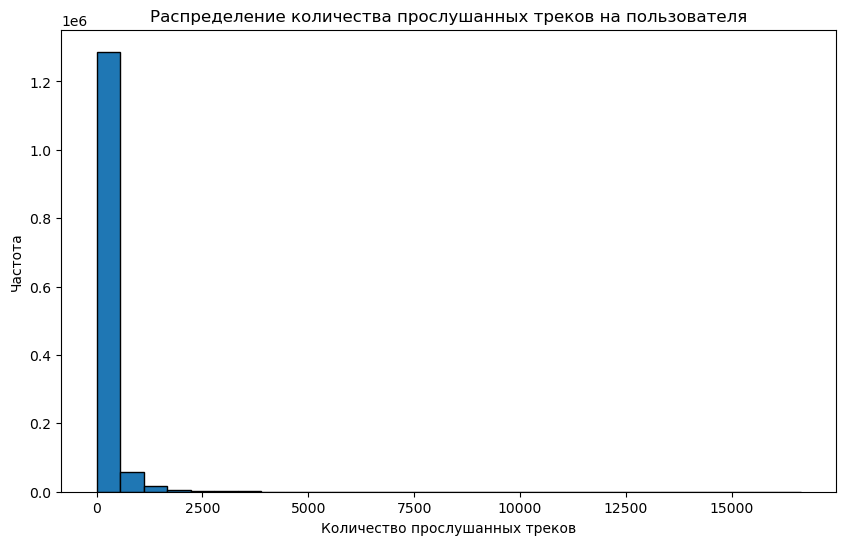

In [144]:
plt.figure(figsize=(10, 6))
plt.hist(user_track_counts, bins=30, edgecolor='black')
plt.title("Распределение количества прослушанных треков на пользователя")
plt.xlabel("Количество прослушанных треков")
plt.ylabel("Частота")
plt.show()

#### 2.1.2 Наиболее популярные треки

In [149]:
popular_tracks = interactions['track_id'].value_counts().head(10)
popular_track_names = pd.merge(popular_tracks.rename('count').reset_index(), 
                               catalog_names[catalog_names['type'] == 'track'][['id', 'name']], 
                               left_on='track_id', right_on='id', 
                               how='left').drop(columns=['id'])
popular_track_names.rename(columns={'index': 'track_id', 'name': 'track_name'}, inplace=True)

In [150]:
print("Наиболее популярные треки:")
print(popular_track_names)

Наиболее популярные треки:
   track_id   count               track_name
0     53404  111062  Smells Like Teen Spirit
1  33311009  106921                 Believer
2    178529  101924                     Numb
3  35505245   99490               I Got Love
4  65851540   86670                   Юность
5  24692821   86246           Way Down We Go
6  32947997   85886             Shape of You
7  51241318   85244               In The End
8    795836   85042        Shape Of My Heart
9  45499814   84748                     Life


#### 2.1.3 Наиболее популярные жанры

In [151]:
# Разворачиваем список жанров в interactions и upd_tracks для анализа
track_genres = upd_tracks[['track_id', 'genres']].explode('genres')
merged_interactions = interactions.merge(track_genres, on='track_id', how='left')
genre_counts = merged_interactions['genres'].value_counts().head(10)

In [153]:
genre_counts.head(20)

genres
11     55578312
75     37799821
102    31092013
20     26626241
3      25303695
68     20120981
16     16291557
2      13166147
14     12772644
47     12437375
Name: count, dtype: int64

In [155]:
# Подключаем названия жанров
popular_genres = pd.merge(genre_counts.rename('count').reset_index(), 
                          catalog_names[catalog_names['type'] == 'genre'][['id', 'name']], 
                          left_on='genres', right_on='id', 
                          how='left').drop(columns=['id'])
popular_genres.rename(columns={'genres': 'genre_id', 'name': 'genre_name'}, inplace=True)

In [156]:
print("\nНаиболее популярные жанры:")
print(popular_genres)


Наиболее популярные жанры:
   genre_id     count   genre_name
0        11  55578312          pop
1        75  37799821          rap
2       102  31092013      allrock
3        20  26626241       ruspop
4         3  25303695       rusrap
5        68  20120981  electronics
6        16  16291557        dance
7         2  13166147      rusrock
8        14  12772644         rock
9        47  12437375        metal


#### 2.1.3 Треки, которые никто не прослушал

In [163]:
all_tracks = set(upd_tracks['track_id'].unique())
listened_tracks = set(interactions['track_id'].unique())

In [165]:
unlistened_tracks = all_tracks - listened_tracks

In [158]:
# Получаем названия треков, которые никто не слушал
unlistened_tracks_df = catalog_names[(catalog_names['type'] == 'track') & (catalog_names['id'].isin(unlistened_tracks))]
print("\nТреки, которые никто не прослушал:")
print(unlistened_tracks_df[['id', 'name']])


Треки, которые никто не прослушал:
Empty DataFrame
Columns: [id, name]
Index: []


### 2.2 Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [168]:
upd_tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [195]:
genresDict = genres.set_index('id')['name'].to_dict()

In [196]:
upd_tracks['genres'] = upd_tracks['genres'].apply(lambda genres_list: [genresDict[genreId] for genreId in genres_list])

In [197]:
albumsDict = albums.set_index('id')['name'].to_dict()
upd_tracks['albums'] = upd_tracks['albums'].apply(lambda albums_list: [albumsDict[albumId] for albumId in albums_list])

In [198]:
artistsDict = artists.set_index('id')['name'].to_dict()
upd_tracks['artists'] = upd_tracks['artists'].apply(lambda artists_list: [artistsDict[artistId] for artistId in artists_list])

In [199]:
upd_tracks.head()

,track_id,albums,artists,genres
0,26,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
3,136,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
4,138,"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop]


In [200]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


### 2.3 Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [201]:
upd_tracks.to_parquet("./data/items.parquet")

In [202]:
interactions.to_parquet("./data/events.parquet")

### 2.4 Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [119]:
del upd_tracks
del interactions
del catalog_names

## === ЭТАП 3 ===

### 3.1 Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [205]:
items = pd.read_parquet("./data/items.parquet")

In [206]:
events = pd.read_parquet("./data/events.parquet")

### 3.2 Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [209]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

In [210]:
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [211]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

In [212]:
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)

In [213]:
print(len(users_train), len(users_test), len(common_users))

1342566 783525 752870


«Холодные» пользователи — те, которые есть в test, но отсутствуют в train. Это соответствует хронологическому порядку, в котором и работает рекомендательная система.

In [214]:
cold_users = set(users_test) - set(users_train)

print(len(cold_users))

30655


### 3.3 Топ популярных

Рассчитаем рекомендации как топ популярных.

### 3.4 Персональные рекомендации

Рассчитаем персональные рекомендации.

### 3.5 Похожие треки

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

### 3.6 Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

### 3.7 Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

### 3.8 Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

### 3.9 === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.